In [1]:
# Configuration file for the ML Food Buddy Recommender project
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
# Constants
MAX_PREP_TIME = 180
OUTLIER_PREP_TIME_THRESHOLD = 600
MAX_ALLOWED_PREP_TIME = 300

In [3]:
# Functions

In [4]:
# Create data loader function
def data_loader(filename: str, source: str = "raw"):
    """
    Load a CSV dataset from the repo's data/raw or data/preprocessed folder.
    
    Parameters:
        filename: str - the CSV file name (can be compressed .zip or .gz)
        source: str - "raw" or "preprocessed" to select folder
    
    Returns:
        pd.DataFrame
    """
    if source not in ["raw", "preprocessed"]:
        raise ValueError("source must be 'raw' or 'preprocessed'")

    cwd = os.getcwd()
    repo_root = cwd

    # Walk upwards until we find the desired folder
    while True:
        data_path = os.path.join(repo_root, "data", source, filename)
        if os.path.exists(data_path):
            break
        parent = os.path.dirname(repo_root)
        if parent == repo_root:  # reached root of filesystem
            raise FileNotFoundError(f"Could not find {filename} in data/{source} from {cwd}")
        repo_root = parent

    # Detect compression type
    compression_type = None
    if filename.endswith('.zip'):
        compression_type = 'zip'
    elif filename.endswith('.gz'):
        compression_type = 'gzip'

    return pd.read_csv(data_path, compression=compression_type)


In [5]:
# Create parse time function
def parse_time(t):
    """
    Parse time in minutes. Supports:
    - Raw numeric strings (e.g., "45")
    - Already numeric values
    
    Returns:
        float (minutes) or np.nan if parsing fails
    """
    if pd.isna(t):
        return np.nan
    if isinstance(t, str):
        t = t.strip()
        if t.startswith("PT"):  # ISO 8601 duration
            hours = re.search(r'(\d+)H', t)
            minutes = re.search(r'(\d+)M', t)
            secs = re.search(r'(\d+)S', t)
            total_minutes = 0
            if hours:
                total_minutes += int(hours.group(1)) * 60
            if minutes:
                total_minutes += int(minutes.group(1))
            if secs:
                total_minutes += int(secs.group(1)) / 60
            return total_minutes if total_minutes > 0 else np.nan
        # fallback: try to parse as float
        try:
            return float(t)
        except:
            return np.nan
    # If already numeric
    try:
        return float(t)
    except:
        return np.nan


In [6]:
# EDA

In [7]:
# Load the dataset
recipes = data_loader("recipes.csv")
recipes.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [8]:
# Missing values
print(recipes.isna().sum())

RecipeId                           0
Name                               0
AuthorId                           0
AuthorName                         0
CookTime                       82545
PrepTime                           0
TotalTime                          0
DatePublished                      0
Description                        5
Images                             1
RecipeCategory                   751
Keywords                       17237
RecipeIngredientQuantities         3
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348071
R

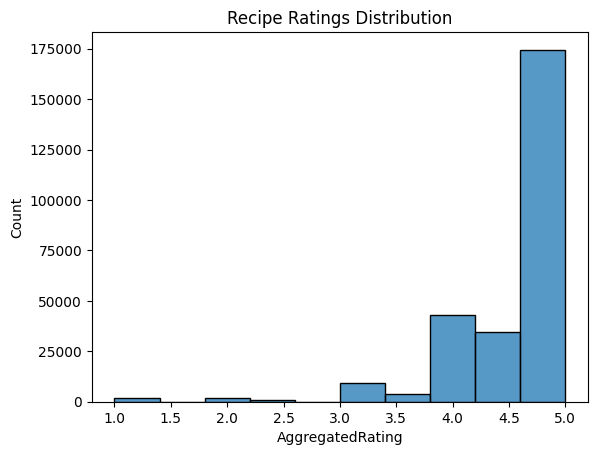

In [10]:
# Ratings distribution
sns.histplot(recipes['AggregatedRating'], bins=10)
plt.title("Recipe Ratings Distribution")
plt.show()

In [ ]:
# Convert PrepTime into minutes
recipes['PrepTime_min'] = recipes['PrepTime'].apply(parse_time)
print(recipes['PrepTime_min'].describe())

count    5.075070e+05
mean     5.775583e+01
std      3.140975e+03
min      1.000000e+00
25%      1.000000e+01
50%      1.500000e+01
75%      2.000000e+01
max      1.440000e+06
Name: PrepTime_min, dtype: float64


In [12]:
# Clip extreme prep times (> MAX_PREP_TIME) for better visualization
prep_times_filtered = recipes['PrepTime_min'].clip(upper=MAX_PREP_TIME).dropna()

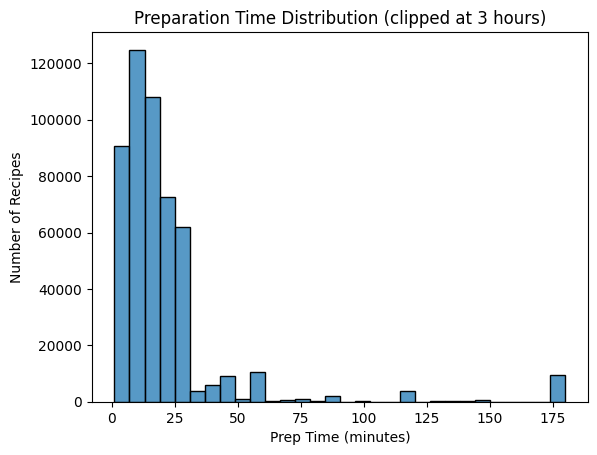

In [13]:
# Plot clipped preparation time distribution
sns.histplot(prep_times_filtered, bins=30)
plt.title("Preparation Time Distribution (clipped at 3 hours)")
plt.xlabel("Prep Time (minutes)")
plt.ylabel("Number of Recipes")
plt.show()

In [ ]:
# Identify recipes with prep times beyond outlier threshold
outlier_recipes = recipes[recipes['PrepTime_min'] > OUTLIER_PREP_TIME_THRESHOLD]
display(outlier_recipes)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,PrepTime_min
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc...",1440.0
1506,2963,Pickled Watermelon Rind,125579,GrandmaIsCooking,PT30M,PT36H,PT36H30M,1999-08-25T06:23:00Z,--Adopted Recipe-- I used to make waterm...,character(0),...,0.0,570.9,29.7,1.8,26.6,0.2,50.0,NaN,"c(""Peel the hard rind from the outside of the ...",2160.0
1585,3047,Dried Figs,1534,Tonkcats,PT72H,PT12H,PT84H,1999-09-30T07:11:00Z,Make and share this Dried Figs recipe from Foo...,character(0),...,0.0,7025.1,599.9,0.0,598.8,0.0,NaN,1 batch,"c(""Place figs in 1 quart of water in which sal...",720.0
1885,3366,Pork Liver Pudding ( Spread / Dip ),1576,Robb Dabbs,PT30M,PT24H,PT24H30M,1999-10-15T03:39:00Z,Make and share this Pork Liver Pudding ( Sprea...,character(0),...,1827.9,723.2,11.3,0.0,0.0,244.1,NaN,1 batch,"c(""Simmer the pork liver and pork chops separa...",1440.0
1990,3476,Friendship Fruit Starter &amp; Cake,1534,Tonkcats,NaN,PT817H30M,PT817H30M,1999-10-19T19:58:00Z,Make and share this Friendship Fruit Starter &...,character(0),...,41.8,326.5,129.4,1.9,117.4,4.0,24.0,NaN,"c(""(Do not refrigerate). Keep on counter top i...",49050.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521871,540724,Best Gluten-Free Bread,1171777,Lunch Lady,PT40M,PT12H,PT12H40M,2020-07-27T14:44:00Z,Make and share this Best Gluten-Free Bread rec...,character(0),...,33.9,229.4,25.9,1.3,3.3,4.2,12.0,1 loaf,"c(""Combine flours, starches, gum, yeast, salt....",720.0
522040,540900,Chokecherry Punch Concentrate or Chokecherry S...,510859,Kirk W.,PT15M,PT72H,PT72H15M,2020-09-03T13:23:00Z,"This is my mother in-laws recipe, she makes it...","""https://img.sndimg.com/food/image/upload/w_55...",...,0.0,57.3,48.6,0.0,23.5,0.0,10.0,3 gallon,"c(""Wash and drain 12 lbs of chokecherries."", ""...",4320.0
522202,541066,Sourdough Starter,2001112113,Jonathan Melendez,NaN,PT168H,PT168H,2020-10-13T19:45:00Z,Follow this easy step-by-step guide to creatin...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,11.2,145.7,17.3,0.8,24.9,NaN,1 starter,"c(""Day 1:"", ""You’ll need two large, wide-mouth...",10080.0
522203,541067,Sourdough Bread,2001112113,Jonathan Melendez,PT50M,PT24H,PT24H50M,2020-10-13T19:46:00Z,Homemade sourdough bread using a mature sourdo...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,3898.7,388.4,15.8,1.4,53.2,NaN,1 loaf,"c(""9:00AM (Day Before Baking):"", ""Make the lev...",1440.0


In [20]:
# Clip extreme preparation times to a reasonable maximum
recipes['PrepTime_min'] = recipes['PrepTime_min'].clip(upper=MAX_ALLOWED_PREP_TIME)